In [1]:
library(ggplot2)
library(SCPA)
library(dplyr)
library(tibble)
library(msigdbr)
library(Seurat)
library(SeuratData)
library(harmony)
library(SeuratWrappers)
library(ggrepel)

This is version 1.5.3 of SCPA
For SCPA tutorials and latest version: https://jackbibby1.github.io/SCPA/
For the SCPA GitHub page: https://github.com/jackbibby1/SCPA
If you use SCPA, please cite: Bibby JA. et al. Cell Rep. 2022



Attachement du package : ‘dplyr’


Les objets suivants sont masqués depuis ‘package:stats’:

    filter, lag


Les objets suivants sont masqués depuis ‘package:base’:

    intersect, setdiff, setequal, union


The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Le chargement a nécessité le package : Rcpp



In [2]:
options(repr.plot.width = 18, repr.plot.height = 17, repr.plot.pointsize = 24)

In [ ]:
load(file = "/home/adufour/work/rds_storage/omics/stem_cells_seurat.Rdata")

In [ ]:
seurat.integrated <- NormalizeData(seurat.integrated) %>% FindVariableFeatures() %>% ScaleData() %>% RunPCA(verbose = FALSE)

In [35]:
epiblast_cells <- seurat_extract(embryo,
                          meta1 = "origin", value_meta1 = "EMB")

esc_cells <- seurat_extract(embryo,
                          meta1 = "origin", value_meta1 = "ESC")

Extracting cells where origin == EMB

Extracting data from the RNA assay

Extracting cells where origin == ESC

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 4.3 GiB”
Extracting data from the RNA assay



In [36]:
tb1 <- msigdbr("Sus scrofa", category = "C2", subcategory = "CP:KEGG")
tb2 <- msigdbr("Sus scrofa", category = "C5", subcategory = "GO:BP")
tb3 <- msigdbr("Sus scrofa", category = "H")

In [37]:
pathways <- rbind(tb1, tb2, tb3) %>%
  format_pathways()

In [38]:
rest_act <- compare_pathways(samples = list(epiblast_cells, esc_cells), 
                             pathways = pathways,
                             parallel = TRUE,
                             cores = 5)

Processing in parallel using 5 cores


Cell numbers in population 1 = 1060

Cell numbers in population 2 = 16237

- If greater than 500 cells, these populations will be downsampled


Excluding 3759 pathway(s) based on min/max genes parameter: GOBP_10_FORMYLTETRAHYDROFOLATE_METABOLIC_PROCESS, GOBP_2FE_2S_CLUSTER_ASSEMBLY, GOBP_3_PHOSPHOADENOSINE_5_PHOSPHOSULFATE_BIOSYNTHETIC_PROCESS, GOBP_3_PHOSPHOADENOSINE_5_PHOSPHOSULFATE_METABOLIC_PROCESS, GOBP_3_UTR_MEDIATED_MRNA_STABILIZATION...


Calculating pathway fold changes...


Performing a two-sample analysis with SCPA...



In [39]:
rest_act <- rest_act %>%
  mutate(color = case_when(FC > 5 & adjPval < 0.01 ~ '#6dbf88',
                           FC < 5 & FC > -5 & adjPval < 0.01 ~ '#84b0f0',
                           FC < -5 & adjPval < 0.01 ~ 'mediumseagreen',
                           FC < 5 & FC > -5 & adjPval > 0.01 ~ 'black'))

In [32]:
write.csv(rest_act, "/home/adufour/work/table/DE_pathway_epi_esc.csv", row.names=FALSE)

In [45]:
# Identify the top 10 hits
Top_Hits = head(rest_act[order(rest_act$FC, decreasing = TRUE),],20)

# Add column label, containing the gene name for the top hits or nothing for all others
rest_act$label = if_else(rest_act$Pathway %in% Top_Hits$Pathway,  
                         rest_act$Pathway, "")

Warning message:
“ggrepel: 20 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


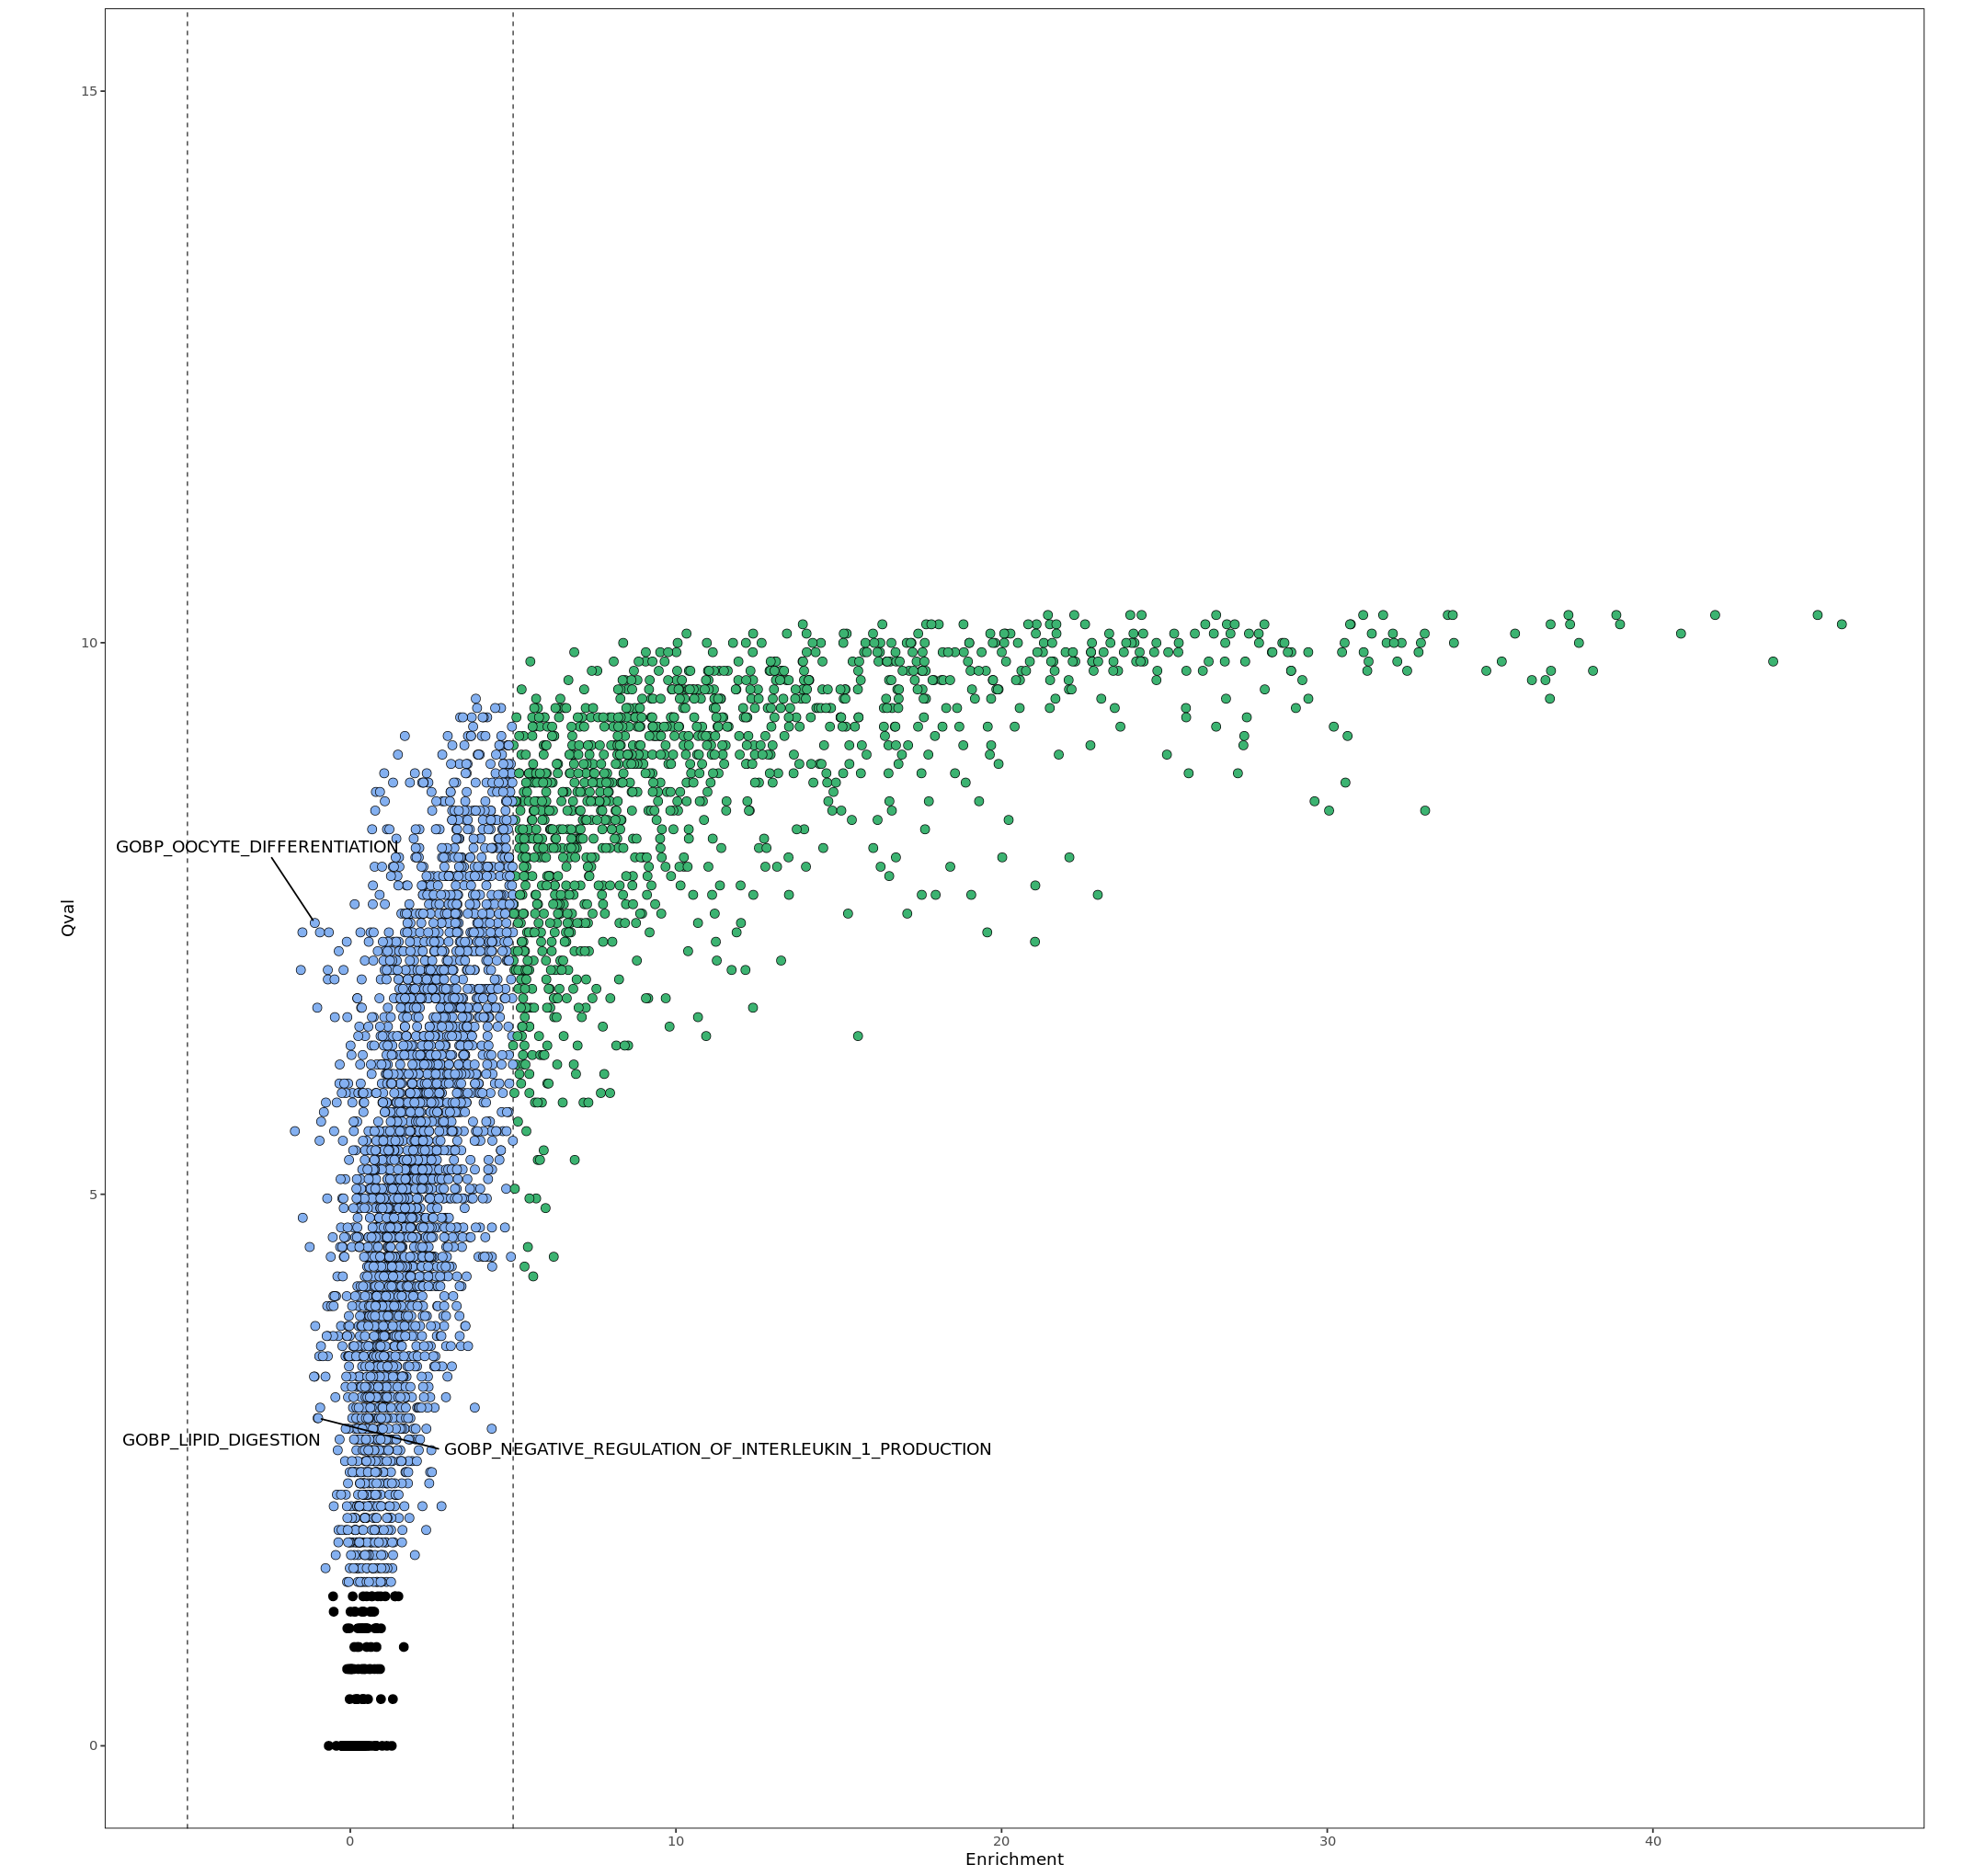

In [46]:
ggplot(rest_act, aes(-FC, qval, label = label)) +
  geom_vline(xintercept = c(-5, 5), linetype = "dashed", col = 'black', lwd = 0.3) +
  geom_point(cex = 2.6, shape = 21, fill = rest_act$color, stroke = 0.3) +
  #geom_point(data = rest_act, shape = 21, cex = 2.8, fill = "orangered2", color = "black", stroke = 0.3) +
  geom_text_repel(max.overlaps = 100, force = 10) +
  #xlim(-400, 400) +
  ylim(0, 15) +
  xlab("Enrichment") +
  ylab("Qval") +
  theme(panel.background = element_blank(),
        panel.border = element_rect(fill = NA),
        aspect.ratio = 1)